In [1]:
import os
par_dir = os.path.abspath(os.path.join(os.getcwd(),os.pardir))
os.chdir(par_dir)

Epoch [2/800] | Train:3.8676 | Val:3.7483
Epoch [20/800] | Train:1.9019 | Val:2.2193
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
Epoch [40/800] | Train:1.2658 | Val:1.5878
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
Epoch [60/800] | Train:0.9665 | Val:1.2540
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
Epoch [80/800] | Train:0.7873 | Val:1.1454
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping co

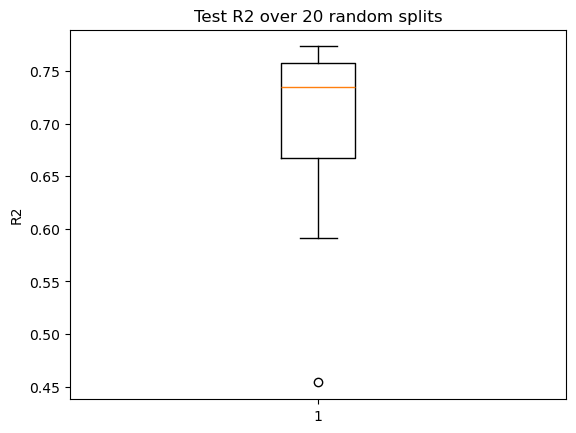

R2 mean: 0.7021124452352524
R2 std : 0.0771772182340222


In [2]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from model.m26_no import MultiDecoderCondVAE
from loss.l26oss_all import integrated_loss_fn
from vae_earlystopping import EarlyStopping

def draw_boxplot(scores, title="R2 scores (test)"):
    plt.figure()
    plt.boxplot(scores, vert=True)
    plt.ylabel("R2")
    plt.title(title)
    plt.show()

x_data = np.load('./data/metal.npy')
c_data = np.load('./data/pre_re_fin_expand.npy')
# s_data = np.load('./data/support.npy')  # 현재 코드에서는 안 쓰고 있습니다.

r2_scores = []
seeds = torch.randint(1, 100, (20,))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for n in seeds:
    seed = int(n)

    # split
    x_train, x_test, c_train, c_test = train_test_split(
        x_data, c_data, random_state=seed, test_size=0.4
    )
    x_val, x_test, c_val, c_test = train_test_split(
        x_test, c_test, random_state=seed, test_size=0.5
    )

    # scaling (fit은 train에만)
    x_scaler = MaxAbsScaler()
    c_scaler = StandardScaler()

    x_train = x_scaler.fit_transform(x_train)
    c_train = c_scaler.fit_transform(c_train)

    x_val = x_scaler.transform(x_val)
    x_test = x_scaler.transform(x_test)
    c_val = c_scaler.transform(c_val)
    c_test = c_scaler.transform(c_test)

    # torch tensors
    x_train = torch.tensor(x_train, dtype=torch.float32)
    x_val   = torch.tensor(x_val,   dtype=torch.float32)
    x_test  = torch.tensor(x_test,  dtype=torch.float32)

    c_train = torch.tensor(c_train, dtype=torch.float32)
    c_val   = torch.tensor(c_val,   dtype=torch.float32)
    c_test  = torch.tensor(c_test,  dtype=torch.float32)

    # loaders (train은 보통 shuffle=True 권장)
    train_loader = DataLoader(TensorDataset(x_train, c_train), batch_size=64, shuffle=True)
    val_loader   = DataLoader(TensorDataset(x_val,   c_val),   batch_size=64, shuffle=False)
    test_loader  = DataLoader(TensorDataset(x_test,  c_test),  batch_size=64, shuffle=False)

    # model
    x_dim = x_train.shape[1]
    c_dim = c_train.shape[1]
    model = MultiDecoderCondVAE(x_dim, c_dim, z_dim=8).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    early_stopping = EarlyStopping(patience=40, min_delta=1e-9)

    history = {
        'train_loss': [], 'train_bce': [], 'train_mse': [], 'train_kl': [],
        'val_loss': [],   'val_bce': [],   'val_mse': [],   'val_kl': []
    }

    epochs = 800
    for epoch in range(1, epochs + 1):
        # ---------- train (epoch) ----------
        model.train()
        t_loss = t_mse = t_bce = t_kl = 0.0

        for x, c in train_loader:
            x, c = x.to(device), c.to(device)
            optimizer.zero_grad()

            bce_logit, binary_out, x_hat, z_mu, z_logvar = model(x, c)
            loss_dict = integrated_loss_fn(bce_logit, x_hat, x, z_mu, z_logvar)

            loss_dict['loss'].backward()
            optimizer.step()

            t_loss += loss_dict['loss'].item()
            t_mse  += loss_dict['mse_loss'].item()
            t_bce  += loss_dict['bce_loss'].item()
            t_kl   += loss_dict['kl_loss'].item()

        avg_train_loss = t_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        history['train_mse'].append(t_mse / len(train_loader))
        history['train_bce'].append(t_bce / len(train_loader))
        history['train_kl'].append(t_kl / len(train_loader))

        # ---------- val (epoch) ----------
        model.eval()
        v_loss = v_mse = v_bce = v_kl = 0.0
        with torch.no_grad():
            for v_x, v_c in val_loader:
                v_x, v_c = v_x.to(device), v_c.to(device)
                v_bce_logit, v_binary_out, v_x_hat, v_mu, v_logvar = model(v_x, v_c)
                loss_dict = integrated_loss_fn(v_bce_logit, v_x_hat, v_x, v_mu, v_logvar)

                v_loss += loss_dict['loss'].item()
                v_mse  += loss_dict['mse_loss'].item()
                v_bce  += loss_dict['bce_loss'].item()
                v_kl   += loss_dict['kl_loss'].item()

        avg_val_loss = v_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)
        history['val_mse'].append(v_mse / len(val_loader))
        history['val_bce'].append(v_bce / len(val_loader))
        history['val_kl'].append(v_kl / len(val_loader))

        if epoch % 20 == 0 or epoch == 2:
            print(f'Epoch [{epoch}/{epochs}] | Train:{avg_train_loss:.4f} | Val:{avg_val_loss:.4f}')

        # early stopping (epoch 단위)
        if early_stopping(avg_val_loss, model):
            break

    # best model 로드
    early_stopping.load_best_model(model)
    model.eval()

    # ---------- test ----------
    x_true = []
    x_pred = []
    with torch.no_grad():
        for x_t, c_t in test_loader:
            x_t, c_t = x_t.to(device), c_t.to(device)
            bce_logit, binary_out, x_hat, z_mu, z_logvar = model(x_t, c_t)


            x_true.append(x_t.cpu().numpy())
            x_pred.append(x_hat.cpu().numpy())

    all_x_true = np.vstack(x_true)
    all_x_hat  = np.vstack(x_pred)

    # R2: 스케일된 공간에서 계산 (원하면 raw로 바꿀 수 있음)
    r2 = r2_score(all_x_true.flatten(), all_x_hat.flatten())
    r2_scores.append(r2)

# 결과 시각화
draw_boxplot(r2_scores, title="Test R2 over 20 random splits")
print("R2 mean:", float(np.mean(r2_scores)))
print("R2 std :", float(np.std(r2_scores)))


In [3]:
r2_no = {"r2_no":r2_scores}

In [4]:
import json

save_path = "r2_no.json"

with open(save_path, 'a') as f:
    # float 타입 데이터도 json.dump를 통해 안전하게 저장됩니다.
    json.dump(r2_no, f, indent=4)

print(f"숫자 형태로 {save_path}에 저장 완료!")

숫자 형태로 r2_no.json에 저장 완료!
